# Interactive Analysis of Unmatched Embryoscope Embryos

This notebook allows you to:
1. **Analyze unmatched Embryoscope embryos** and their characteristics
2. **Check PatientID presence** in Clinisys data
3. **Query source gold tables** for detailed investigation
4. **Investigate specific cases** with custom queries

In [1]:
import duckdb
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Connect to data lake
con = duckdb.connect('../database/huntington_data_lake.duckdb')
print("Connected to Huntington Data Lake")

Connected to Huntington Data Lake


## 1. Overview of Unmatched Embryoscope Embryos

In [3]:
# Get overall statistics
print("=" * 80)
print("OVERVIEW OF UNMATCHED EMBRYOSCOPE EMBRYOS")
print("=" * 80)

# Total Embryoscope embryos
total_embryoscope = con.execute("SELECT COUNT(*) FROM gold.embryoscope_embrioes").fetchone()[0]

# Matched embryos
matched_embryoscope = con.execute("""
    SELECT COUNT(DISTINCT embryo_EmbryoID) 
    FROM gold.embryoscope_clinisys_combined 
    WHERE embryo_EmbryoID IS NOT NULL
""").fetchone()[0]

# Unmatched embryos
unmatched_embryoscope = total_embryoscope - matched_embryoscope

print(f"Total Embryoscope embryos: {total_embryoscope:,}")
print(f"Matched embryos: {matched_embryoscope:,}")
print(f"Unmatched embryos: {unmatched_embryoscope:,}")
print(f"Match rate: {(matched_embryoscope/total_embryoscope*100):.2f}%")

OVERVIEW OF UNMATCHED EMBRYOSCOPE EMBRYOS
Total Embryoscope embryos: 128,465
Matched embryos: 58,709
Unmatched embryos: 69,756
Match rate: 45.70%


## 2. PatientID Analysis

PatientID Status for Unmatched Embryos:
patientid_status  count  percentage
           VALID  67588       97.29
  INVALID_FORMAT   1868        2.69
           EMPTY     13        0.02


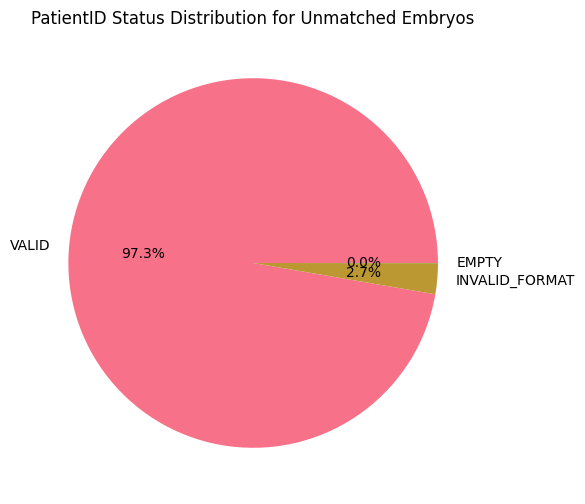

In [4]:
# Analyze PatientID status for unmatched embryos
patientid_analysis = con.execute("""
    SELECT 
        CASE 
            WHEN patient_PatientID IS NULL THEN 'NULL'
            WHEN TRIM(patient_PatientID) = '' THEN 'EMPTY'
            WHEN TRY_CAST(REPLACE(patient_PatientID, '.', '') AS INTEGER) IS NULL THEN 'INVALID_FORMAT'
            ELSE 'VALID'
        END as patientid_status,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
    FROM gold.embryoscope_embrioes
    WHERE embryo_EmbryoID NOT IN (
        SELECT DISTINCT embryo_EmbryoID 
        FROM gold.embryoscope_clinisys_combined 
        WHERE embryo_EmbryoID IS NOT NULL
    )
    GROUP BY patientid_status
    ORDER BY count DESC
""").df()

print("PatientID Status for Unmatched Embryos:")
print(patientid_analysis.to_string(index=False))

# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.pie(patientid_analysis['count'], labels=patientid_analysis['patientid_status'], autopct='%1.1f%%')
plt.title('PatientID Status Distribution for Unmatched Embryos')
plt.show()

## 3. PatientID Presence in Clinisys

In [5]:
# Get unique PatientIDs from Clinisys
clinisys_patientids = con.execute("""
    SELECT DISTINCT micro_prontuario
    FROM gold.clinisys_embrioes
    WHERE micro_prontuario IS NOT NULL
""").fetchdf()['micro_prontuario'].tolist()

print(f"Unique PatientIDs in Clinisys: {len(clinisys_patientids):,}")

# Analyze PatientID presence for unmatched embryos
unmatched_with_patientid = con.execute("""
    SELECT DISTINCT
        embryo_EmbryoID,
        embryo_FertilizationTime,
        embryo_embryo_number,
        patient_PatientID,
        CASE 
            WHEN patient_PatientID IS NULL OR TRIM(patient_PatientID) = '' THEN NULL
            WHEN TRY_CAST(REPLACE(patient_PatientID, '.', '') AS INTEGER) IS NULL THEN NULL
            ELSE TRY_CAST(REPLACE(patient_PatientID, '.', '') AS INTEGER)
        END as patient_PatientID_clean
    FROM gold.embryoscope_embrioes
    WHERE embryo_EmbryoID NOT IN (
        SELECT DISTINCT embryo_EmbryoID 
        FROM gold.embryoscope_clinisys_combined 
        WHERE embryo_EmbryoID IS NOT NULL
    )
    AND patient_PatientID IS NOT NULL 
    AND TRIM(patient_PatientID) != ''
    AND TRY_CAST(REPLACE(patient_PatientID, '.', '') AS INTEGER) IS NOT NULL
    ORDER BY embryo_FertilizationTime DESC
""").df()

# Check which PatientIDs are in Clinisys
unmatched_with_patientid['found_in_clinisys'] = unmatched_with_patientid['patient_PatientID_clean'].isin(clinisys_patientids)

print(f"\nPatientID Presence Analysis:")
print(f"Total unmatched embryos with valid PatientID: {len(unmatched_with_patientid):,}")
print(f"PatientIDs found in Clinisys: {unmatched_with_patientid['found_in_clinisys'].sum():,}")
print(f"PatientIDs NOT found in Clinisys: {(~unmatched_with_patientid['found_in_clinisys']).sum():,}")
print(f"Percentage found in Clinisys: {(unmatched_with_patientid['found_in_clinisys'].sum()/len(unmatched_with_patientid)*100):.1f}%")

Unique PatientIDs in Clinisys: 15,561

PatientID Presence Analysis:
Total unmatched embryos with valid PatientID: 67,588
PatientIDs found in Clinisys: 7,016
PatientIDs NOT found in Clinisys: 60,572
Percentage found in Clinisys: 10.4%


## 4. Date Range Analysis

Recent Dates with Unmatched Embryos:
      date  unmatched_count  unique_patients
2025-07-22                9                2
2025-07-17               53                3
2025-07-16                3                2
2025-07-15               25                6
2025-07-14               11                3
2025-07-13                5                1
2025-07-12               18                4
2025-07-11               33                8
2025-07-10               38                6
2025-07-09                2                2
2025-07-08                2                2
2025-07-05               10                3
2025-07-03               17                6
2025-07-02               30                4
2025-07-01               32                1
2025-06-29                2                2
2025-06-28                3                1
2025-06-27                2                2
2025-06-26                2                1
2025-06-24               33                3


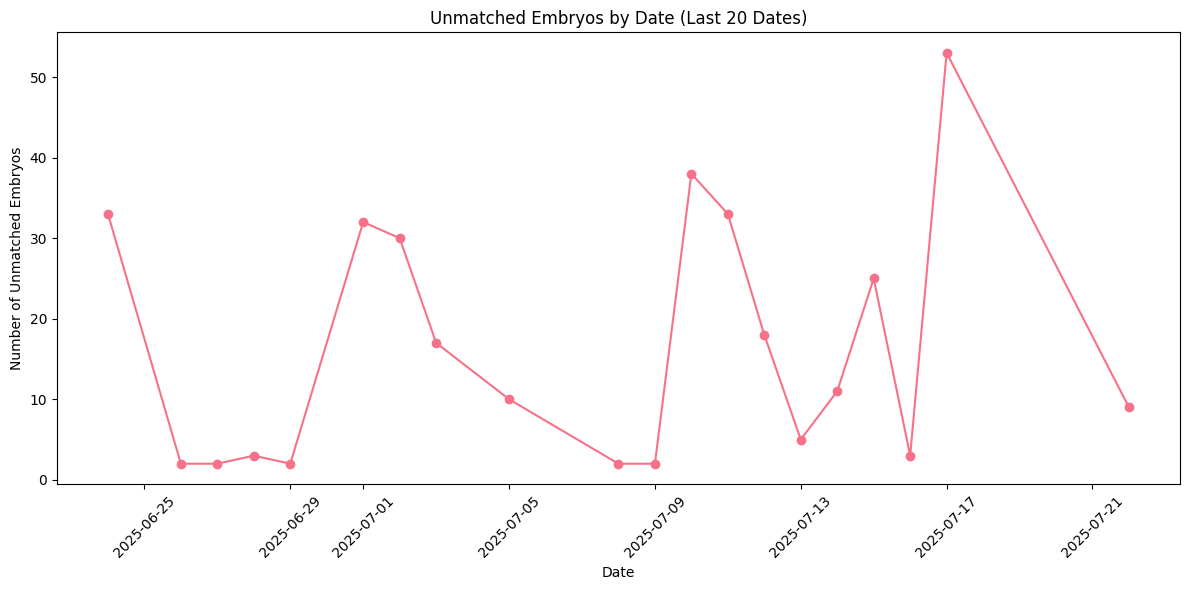

In [6]:
# Analyze date ranges
date_analysis = con.execute("""
    SELECT 
        CAST(embryo_FertilizationTime AS DATE) as date,
        COUNT(*) as unmatched_count,
        COUNT(DISTINCT patient_PatientID) as unique_patients
    FROM gold.embryoscope_embrioes
    WHERE embryo_EmbryoID NOT IN (
        SELECT DISTINCT embryo_EmbryoID 
        FROM gold.embryoscope_clinisys_combined 
        WHERE embryo_EmbryoID IS NOT NULL
    )
    GROUP BY CAST(embryo_FertilizationTime AS DATE)
    ORDER BY date DESC
    LIMIT 20
""").df()

print("Recent Dates with Unmatched Embryos:")
print(date_analysis.to_string(index=False))

# Visualize the trend
plt.figure(figsize=(12, 6))
plt.plot(date_analysis['date'], date_analysis['unmatched_count'], marker='o')
plt.title('Unmatched Embryos by Date (Last 20 Dates)')
plt.xlabel('Date')
plt.ylabel('Number of Unmatched Embryos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Interactive Query Tool

Use the functions below to investigate specific cases:

In [15]:
def investigate_patientid(patientid):
    """Investigate a specific PatientID in both systems."""
    print(f"\n{'='*60}")
    print(f"INVESTIGATING PATIENTID: {patientid}")
    print(f"{'='*60}")
    
    # Check Embryoscope data
    print("\n1. EMBRYOSCOPE DATA:")
    embryoscope_data = con.execute("""
        SELECT 
            embryo_EmbryoID,
            embryo_FertilizationTime,
            embryo_embryo_number,
            patient_PatientID,
            treatment_TreatmentName,
            embryo_EmbryoFate
        FROM gold.embryoscope_embrioes
        WHERE patient_PatientID = ?
        ORDER BY embryo_FertilizationTime DESC
    """, [float(patientid.replace('.', ''))]).df()
    
    if len(embryoscope_data) > 0:
        print(f"Found {len(embryoscope_data)} Embryoscope records:")
        print(embryoscope_data.to_string(index=False))
    else:
        print("No Embryoscope records found")
    
    # Check Clinisys data
    print("\n2. CLINISYS DATA:")
    clinisys_data = con.execute("""
        SELECT 
            oocito_id,
            micro_prontuario,
            micro_Data_DL,
            oocito_embryo_number,
            oocito_Maturidade,
            oocito_TCD
        FROM gold.clinisys_embrioes
        WHERE micro_prontuario = ?
        ORDER BY micro_Data_DL DESC
    """, [float(patientid.replace('.', ''))]).df()
    
    if len(clinisys_data) > 0:
        print(f"Found {len(clinisys_data)} Clinisys records:")
        print(clinisys_data.to_string(index=False))
    else:
        print("No Clinisys records found")

def investigate_date(date_str):
    """Investigate embryos and records for a specific date."""
    print(f"\n{'='*60}")
    print(f"INVESTIGATING DATE: {date_str}")
    print(f"{'='*60}")
    
    # Embryoscope embryos on this date
    print("\n1. EMBRYOSCOPE EMBRYOS ON THIS DATE:")
    embryoscope_date = con.execute("""
        SELECT 
            embryo_EmbryoID,
            embryo_FertilizationTime,
            embryo_embryo_number,
            patient_PatientID,
            treatment_TreatmentName
        FROM gold.embryoscope_embrioes
        WHERE CAST(embryo_FertilizationTime AS DATE) = ?
        ORDER BY embryo_FertilizationTime
    """, [date_str]).df()
    
    print(f"Found {len(embryoscope_date)} Embryoscope embryos:")
    print(embryoscope_date.to_string(index=False))
    
    # Clinisys records on this date
    print("\n2. CLINISYS RECORDS ON THIS DATE:")
    clinisys_date = con.execute("""
        SELECT 
            oocito_id,
            micro_prontuario,
            micro_Data_DL,
            oocito_embryo_number,
            oocito_Maturidade
        FROM gold.clinisys_embrioes
        WHERE CAST(micro_Data_DL AS DATE) = ?
        ORDER BY micro_Data_DL
    """, [date_str]).df()
    
    print(f"Found {len(clinisys_date)} Clinisys records:")
    print(clinisys_date.to_string(index=False))

def investigate_embryo_number(embryo_number):
    """Investigate a specific embryo number across both systems."""
    print(f"\n{'='*60}")
    print(f"INVESTIGATING EMBRYO NUMBER: {embryo_number}")
    print(f"{'='*60}")
    
    # Embryoscope embryos with this number
    print("\n1. EMBRYOSCOPE EMBRYOS WITH THIS NUMBER:")
    embryoscope_embryo = con.execute("""
        SELECT 
            embryo_EmbryoID,
            embryo_FertilizationTime,
            embryo_embryo_number,
            patient_PatientID,
            treatment_TreatmentName
        FROM gold.embryoscope_embrioes
        WHERE embryo_embryo_number = ?
        ORDER BY embryo_FertilizationTime DESC
    """, [embryo_number]).df()
    
    print(f"Found {len(embryoscope_embryo)} Embryoscope embryos:")
    print(embryoscope_embryo.to_string(index=False))
    
    # Clinisys records with this embryo number
    print("\n2. CLINISYS RECORDS WITH THIS EMBRYO NUMBER:")
    clinisys_embryo = con.execute("""
        SELECT 
            oocito_id,
            micro_prontuario,
            micro_Data_DL,
            oocito_embryo_number,
            oocito_Maturidade
        FROM gold.clinisys_embrioes
        WHERE oocito_embryo_number = ?
        ORDER BY micro_Data_DL DESC
    """, [embryo_number]).df()
    
    print(f"Found {len(clinisys_embryo)} Clinisys records:")
    print(clinisys_embryo.to_string(index=False))

def custom_query(query):
    """Execute a custom SQL query."""
    try:
        result = con.execute(query).df()
        print(f"Query executed successfully. Found {len(result)} rows.")
        return result
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

## 6. Sample Investigations

Here are some example investigations you can run:

In [16]:
# Example 1: Investigate a PatientID that exists in both systems but doesn't match
investigate_patientid('864.116')


INVESTIGATING PATIENTID: 864.116

1. EMBRYOSCOPE DATA:


ConversionException: Conversion Error: Could not convert string 'tw' to DOUBLE when casting from source column patient_PatientID

LINE 10:         WHERE patient_PatientID = ?
                       ^

In [ ]:
# Example 2: Investigate a recent date with unmatched embryos
investigate_date('2025-07-22')

In [ ]:
# Example 3: Investigate a specific embryo number
investigate_embryo_number(1)

## 7. Custom Analysis

Use the cell below for your own custom queries:

In [ ]:
# Example custom query - modify as needed
custom_query_result = custom_query("""
    SELECT 
        patient_PatientID,
        COUNT(*) as embryo_count,
        MIN(embryo_FertilizationTime) as earliest_date,
        MAX(embryo_FertilizationTime) as latest_date
    FROM gold.embryoscope_embrioes
    WHERE embryo_EmbryoID NOT IN (
        SELECT DISTINCT embryo_EmbryoID 
        FROM gold.embryoscope_clinisys_combined 
        WHERE embryo_EmbryoID IS NOT NULL
    )
    AND patient_PatientID IS NOT NULL
    GROUP BY patient_PatientID
    HAVING COUNT(*) > 10
    ORDER BY embryo_count DESC
    LIMIT 10
""")

if custom_query_result is not None:
    print("\nPatients with most unmatched embryos:")
    print(custom_query_result.to_string(index=False))

## 8. Summary and Next Steps

Based on the analysis above, you can:

1. **Investigate specific PatientIDs** that appear in both systems but don't match
2. **Check date ranges** to understand temporal coverage differences
3. **Analyze embryo numbering** patterns to identify systematic differences
4. **Run custom queries** to explore specific hypotheses

### Quick Investigation Examples:

```python
# Check a specific PatientID
investigate_patientid('833.901')

# Check a specific date
investigate_date('2025-07-17')

# Check a specific embryo number
investigate_embryo_number(5)
```

### Common Custom Queries:

```sql
-- Find PatientIDs that exist in both systems but don't match
SELECT DISTINCT e.patient_PatientID
FROM gold.embryoscope_embrioes e
JOIN gold.clinisys_embrioes c ON c.micro_prontuario = TRY_CAST(REPLACE(e.patient_PatientID, '.', '') AS INTEGER)
WHERE e.embryo_EmbryoID NOT IN (
    SELECT DISTINCT embryo_EmbryoID FROM gold.embryoscope_clinisys_combined WHERE embryo_EmbryoID IS NOT NULL
)

-- Find date ranges for each system
SELECT 'Embryoscope' as system, MIN(embryo_FertilizationTime) as earliest, MAX(embryo_FertilizationTime) as latest
FROM gold.embryoscope_embrioes
UNION ALL
SELECT 'Clinisys' as system, MIN(micro_Data_DL) as earliest, MAX(micro_Data_DL) as latest
FROM gold.clinisys_embrioes
```

In [17]:
# Close the database connection
con.close()
print("Database connection closed.")

Database connection closed.
